# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-2000a']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.25 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (26312/26312), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical scale; actual layers scaled below to match 0.5/0.25


backbone:
  - [-1, 1, TorchVision, [768, mobilenet_v3_small, DEFAULT, True, 2, True]]  # 0

head:
  # Extract features from MobileNetV3 Small
  - [0, 1, Index, [24, 3]]           # 1: P3
  - [1, 1, CBAM, [24]]               # 2: 

  - [0, 1, Index, [48, 9]]           # 3: P4
  - [3, 1, CBAM, [48]]               # 4: 

  - [0, 1, Index, [576, 13]]         # 5: P5
  - [5, 1, CBAM, [576]]              # 6: 

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]] # 13
  - [[13, 7], 1, Concat, [1]]                  # 14
  - [-1, 1, C3k2, [64, False]]                 # 15

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                  # 16
  - [[16, 12], 1, Concat, [1]]                 # 17
  - [-1, 1, C3k2, [128, False]]                # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                 # 19
  - [[19, 9], 1, Concat, [1]]                  # 20
  - [-1, 1, C3k2, [256, True]]                 # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]            # 22



  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 16, 320, 320])
# 2 torch.Size([1, 16, 160, 160])
# 3 torch.Size([1, 24, 80, 80])
# 4 torch.Size([1, 24, 80, 80])
# 5 torch.Size([1, 40, 40, 40])
# 6 torch.Size([1, 40, 40, 40])
# 7 torch.Size([1, 40, 40, 40])
# 8 torch.Size([1, 48, 40, 40])
# 9 torch.Size([1, 48, 40, 40])
# 10 torch.Size([1, 96, 20, 20])
# 11 torch.Size([1, 96, 20, 20])
# 12 torch.Size([1, 96, 20, 20])
# 13 torch.Size([1, 576, 20, 20])
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 159MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train
val: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val
test: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=10,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.116 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 4.50MB/s]
E0000 00:00:1745664512.742585      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745664512.796477      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    927008  ultralytics.nn.modules.block.TorchVision     ['mobilenet_v3_small', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [3]                           
  2                   1  1       698  ultralytics.nn.modules.conv.CBAM             [24]                          
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [9]                           
  4                   3  1      2450  ultralytics.nn.modules.conv.CBAM             [48]                          
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [13]                          
  6                   5  1    332450  ultralytics.nn.modules.conv.CBAM             [576]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/train... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:12<00:00, 166.21it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9561.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9564.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9570.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9571.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/val... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 136.36it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 78 weight(decay=0.0), 109 weight(decay=0.0005), 105 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.38G      4.255      36.27      3.016        138        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        250       1262      0.197     0.0293     0.0289    0.00582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.93G      3.348      3.285      1.351        108        640: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

                   all        250       1262      0.328      0.252      0.142     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.93G      3.144      2.516      1.219        107        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


                   all        250       1262       0.37      0.238      0.163     0.0401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.93G      3.071      2.122      1.189        197        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        250       1262      0.398      0.294       0.21     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.93G      2.938       1.86      1.171        111        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        250       1262      0.419      0.319      0.243      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.93G       2.87      1.728      1.143        141        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]

                   all        250       1262      0.491      0.373      0.312     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.93G      2.841      1.632      1.147        128        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        250       1262      0.464      0.373      0.306     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.93G      2.779      1.519      1.138        134        640: 100%|██████████| 125/125 [00:51<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        250       1262      0.473      0.359      0.311     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.93G      2.711      1.455      1.102        155        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


                   all        250       1262      0.522      0.365      0.341     0.0928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.93G      2.707      1.415      1.104        163        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

                   all        250       1262       0.53      0.384      0.327     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.93G      2.674      1.344      1.078        126        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

                   all        250       1262       0.53      0.411      0.368      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.93G      2.632      1.325      1.112        141        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        250       1262      0.525      0.419      0.366      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.93G      2.619      1.303      1.104        132        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

                   all        250       1262      0.522      0.388      0.329     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.93G      2.639      1.311      1.076        173        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        250       1262      0.481      0.386      0.327      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.93G      2.594      1.272      1.071        122        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        250       1262      0.582      0.416      0.399      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.93G      2.601      1.261      1.077        120        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

                   all        250       1262      0.589       0.44      0.427      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.93G      2.565       1.24      1.071         95        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

                   all        250       1262       0.57        0.4      0.403      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.93G      2.559      1.234      1.054        121        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

                   all        250       1262      0.577      0.443      0.408      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.93G      2.479      1.199      1.056        144        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

                   all        250       1262      0.597      0.413      0.398      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.93G      2.487      1.179      1.061        148        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        250       1262      0.625       0.46      0.446      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.93G      2.484       1.19      1.053        168        640: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

                   all        250       1262      0.549      0.437      0.418      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.93G      2.441      1.164      1.055        138        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


                   all        250       1262      0.618      0.433       0.43      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.93G      2.436      1.142      1.044        193        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        250       1262      0.594      0.449      0.441      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.93G      2.444      1.146      1.037        148        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        250       1262      0.611      0.441      0.444      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.93G      2.377      1.096      1.022        169        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        250       1262      0.663      0.462      0.465      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.93G      2.385      1.122      1.031        116        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        250       1262      0.566      0.415        0.4      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.93G       2.41      1.137      1.049        163        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        250       1262      0.624       0.47       0.47      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.93G      2.357      1.107      1.025        131        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        250       1262      0.633      0.471      0.476      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.93G      2.391       1.13      1.033        113        640: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        250       1262       0.63      0.481      0.486      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.93G      2.336      1.087      1.017        112        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

                   all        250       1262      0.637      0.476      0.485      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.93G      2.338      1.092       1.02        119        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        250       1262      0.597      0.456       0.46      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.93G      2.369      1.108       1.03        151        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        250       1262      0.548      0.365      0.375      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.93G      2.338       1.09       1.02        113        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


                   all        250       1262      0.629      0.451      0.462      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.93G      2.319      1.089      1.014        142        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

                   all        250       1262      0.669      0.471       0.49      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.93G      2.345      1.091      1.016        130        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        250       1262      0.651      0.459      0.478      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.93G      2.333      1.081      1.017        130        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


                   all        250       1262      0.637      0.448      0.469      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.93G      2.275      1.043      1.004        146        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        250       1262      0.625      0.468      0.467      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.93G      2.275      1.048      1.001        128        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

                   all        250       1262      0.691      0.493      0.512      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.93G      2.261      1.035      1.009        120        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        250       1262      0.657       0.49      0.493       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.93G      2.265      1.036      1.011        130        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250       1262      0.664      0.464      0.479      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.93G      2.286      1.053      1.002        172        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        250       1262      0.684      0.475      0.503      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.93G      2.238      1.033     0.9994        149        640: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


                   all        250       1262      0.671      0.502      0.511      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.93G      2.296       1.06      1.019        125        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

                   all        250       1262      0.662      0.475      0.492       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.93G       2.24      1.016     0.9965        105        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

                   all        250       1262      0.667      0.503       0.51      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.93G      2.227      1.045      1.005        150        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        250       1262      0.665      0.481        0.5       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.93G      2.251      1.037     0.9962        132        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

                   all        250       1262      0.626      0.445      0.477      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.93G      2.231      1.018      0.993        147        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        250       1262       0.66      0.452       0.49      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.93G      2.212      1.011     0.9839        114        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

                   all        250       1262      0.676      0.495       0.53      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.93G      2.211          1     0.9924        169        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

                   all        250       1262       0.68      0.517       0.54      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.93G      2.192     0.9985     0.9865         92        640: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        250       1262      0.679      0.496      0.524      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.93G       2.21      1.025     0.9944        132        640: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

                   all        250       1262      0.652      0.505       0.52      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.93G      2.186     0.9891     0.9918        104        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

                   all        250       1262      0.686      0.479      0.517      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.93G      2.204     0.9976     0.9935        181        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


                   all        250       1262       0.69       0.49      0.525      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.93G      2.188      1.002     0.9929        157        640: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

                   all        250       1262      0.679      0.492      0.523      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.93G      2.207      1.025      0.999        174        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        250       1262      0.684      0.483      0.515      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.93G      2.163      0.972       0.98        153        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250       1262      0.664      0.524      0.536      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.93G      2.173      0.982     0.9992        162        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        250       1262      0.683      0.469      0.505      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.93G      2.135     0.9533     0.9711        147        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        250       1262      0.705      0.493      0.525       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.93G      2.149     0.9708     0.9812        105        640: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.57it/s]


                   all        250       1262      0.657      0.507      0.528      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.93G      2.137     0.9666     0.9841         98        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]


                   all        250       1262      0.705      0.471      0.511      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.93G      2.161     0.9788     0.9767         80        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

                   all        250       1262      0.683      0.518      0.538      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.93G      2.126     0.9588     0.9733         98        640: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

                   all        250       1262      0.667      0.506      0.529      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.93G      2.086     0.9427     0.9636        109        640: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

                   all        250       1262      0.674      0.505      0.528      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.93G      2.145     0.9628     0.9812        142        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

                   all        250       1262      0.705      0.516      0.543        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.93G      2.139     0.9607      0.972        140        640: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        250       1262      0.689      0.501      0.541      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.93G      2.082     0.9429     0.9899        103        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]

                   all        250       1262      0.672      0.522      0.548      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.93G      2.118     0.9718     0.9757        120        640: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        250       1262      0.711      0.519      0.552        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.93G      2.129     0.9618     0.9687        100        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all        250       1262      0.707      0.509      0.545      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.93G      2.107     0.9536     0.9627        169        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250       1262      0.682      0.508      0.539      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.93G      2.119     0.9389     0.9687        125        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

                   all        250       1262       0.71      0.521      0.551      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.93G      2.074     0.9272     0.9604        185        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]

                   all        250       1262      0.728       0.51      0.559      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.93G      2.102     0.9338     0.9603        128        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        250       1262        0.7      0.519      0.547      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.93G      2.056     0.9123     0.9595        139        640: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250       1262      0.696      0.503      0.548      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.93G      2.094     0.9402      0.958        122        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        250       1262      0.689      0.485      0.515      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.93G      2.074     0.9327     0.9558        142        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

                   all        250       1262      0.706      0.516      0.552      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.93G      2.077     0.9338     0.9691        145        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

                   all        250       1262      0.717      0.521      0.557      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.93G      2.062     0.9211     0.9619        101        640: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        250       1262      0.695      0.517      0.542      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.93G      2.041      0.913     0.9605        154        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all        250       1262      0.703      0.513       0.55      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.93G      2.093      0.937     0.9706        151        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        250       1262      0.709      0.497      0.541      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.93G      2.028     0.9095     0.9688        234        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250       1262      0.711      0.516      0.553      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.93G      2.017     0.8996     0.9536        132        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

                   all        250       1262      0.714      0.521      0.551      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.93G      2.034     0.8975     0.9597        165        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        250       1262      0.679      0.494      0.519      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.93G      2.064     0.9159     0.9661        118        640: 100%|██████████| 125/125 [00:58<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]


                   all        250       1262      0.692      0.525      0.561      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.93G      2.021     0.8906      0.948        137        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        250       1262      0.706      0.532      0.564      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.93G      2.023     0.9004      0.939        150        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        250       1262      0.706      0.506      0.549      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.93G      2.014     0.8976     0.9511        148        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

                   all        250       1262      0.715      0.522      0.552       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.93G      1.977     0.8873     0.9482        130        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all        250       1262      0.696       0.54      0.555      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.93G      1.997     0.8912     0.9594        126        640: 100%|██████████| 125/125 [00:58<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]

                   all        250       1262      0.719       0.51      0.562      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.93G      1.998     0.8956     0.9458        197        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        250       1262      0.718      0.532      0.569       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.93G      1.997     0.8883     0.9494         83        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

                   all        250       1262      0.719      0.522      0.559      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.93G      2.008     0.8994      0.945        149        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

                   all        250       1262      0.749      0.518      0.566      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.93G      1.981     0.8732     0.9485        161        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

                   all        250       1262      0.729      0.521      0.566      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.93G      1.961     0.8738     0.9485        125        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        250       1262      0.721      0.537      0.566       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.93G      1.966     0.8724     0.9427        118        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

                   all        250       1262       0.72      0.547      0.582      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.93G       1.95     0.8694     0.9444        118        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

                   all        250       1262      0.745      0.527      0.578       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.93G      1.978     0.8931      0.955        109        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250       1262      0.735      0.525      0.571      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.93G      1.969      0.872     0.9357        117        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        250       1262      0.724      0.535       0.57      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.93G      1.943     0.8605     0.9435         98        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        250       1262      0.728      0.541      0.581      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.93G       1.95     0.8609     0.9389        149        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]

                   all        250       1262      0.728      0.553      0.592      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.93G      1.934     0.8519     0.9416        133        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        250       1262      0.727      0.538      0.582      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.93G      1.952     0.8685     0.9439        124        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        250       1262      0.752      0.526      0.576      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.93G       1.95     0.8625     0.9444        169        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        250       1262      0.716      0.528      0.563      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.93G      1.953     0.8643     0.9342        187        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        250       1262      0.723      0.529      0.579      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.93G       1.95     0.8645     0.9507        197        640: 100%|██████████| 125/125 [00:58<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        250       1262      0.723       0.53       0.58      0.221
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 95, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



105 epochs completed in 1.752 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 5.6MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 5.6MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 212 layers, 2,635,153 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


                   all        250       1262      0.721      0.547      0.582      0.228


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d81e0b3f190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
!zip -r yolo11_mobilenet.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/val_batch2_pred.jpg (deflated 14%)
  adding: kaggle/working/model/P_curve.png (deflated 15%)
  adding: kaggle/working/model/val_batch1_labels.jpg (deflated 8%)
  adding: kaggle/working/model/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/model/args.yaml (deflated 54%)
  adding: kaggle/working/model/R_curve.png (deflated 21%)
  adding: kaggle/working/model/train_batch2.jpg (deflated 7%)
  adding: kaggle/working/model/train_batch1.jpg (deflated 4%)
  adding: kaggle/working/model/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/model/val_batch2_labels.jpg (deflated 13%)
  adding: kaggle/working/model/confusion_matrix.png (deflated 37%)
  adding: kaggle/working/model/labels.jpg (deflated 34%)
  adding: kaggle/working/model/labels_correlogram.jpg (deflated 40%)
  adding: kaggle/working/model/results.png (deflated 7%)
  adding: kaggle/working/model/train_batch0.jpg (deflated 7%)
  ad

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



image 1/1 /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg: 384x640 6 humans, 59.0ms
Speed: 2.3ms preprocess, 59.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


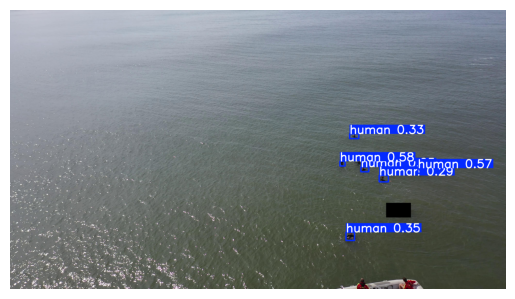

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 212 layers, 2,635,153 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/test... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 139.95it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


                   all        250       1350      0.759       0.61      0.639      0.245


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.4ms preprocess, 3.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d8329a3a890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.03

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)